ULA iter    0, min=-1.113e+04, max=1.235e+03 grad_norm=9.395e+05, sample_mean=3.079e-04, sample_std=5.017e-04
ULA iter   50, min=-2.576e+02, max=1.766e+02 grad_norm=1.786e+04, sample_mean=1.225e-01, sample_std=2.073e-01
ULA iter  100, min=-1.630e+02, max=1.598e+02 grad_norm=1.455e+04, sample_mean=1.231e-01, sample_std=2.114e-01
ULA iter  150, min=-1.596e+02, max=1.539e+02 grad_norm=1.439e+04, sample_mean=1.232e-01, sample_std=2.134e-01
ULA iter  200, min=-1.559e+02, max=1.709e+02 grad_norm=1.437e+04, sample_mean=1.231e-01, sample_std=2.153e-01
ULA iter  250, min=-1.513e+02, max=1.580e+02 grad_norm=1.444e+04, sample_mean=1.231e-01, sample_std=2.172e-01
ULA iter  300, min=-1.423e+02, max=1.536e+02 grad_norm=1.437e+04, sample_mean=1.232e-01, sample_std=2.190e-01
ULA iter  350, min=-1.706e+02, max=1.594e+02 grad_norm=1.437e+04, sample_mean=1.231e-01, sample_std=2.208e-01
ULA iter  400, min=-1.546e+02, max=1.676e+02 grad_norm=1.450e+04, sample_mean=1.232e-01, sample_std=2.226e-01
ULA iter  

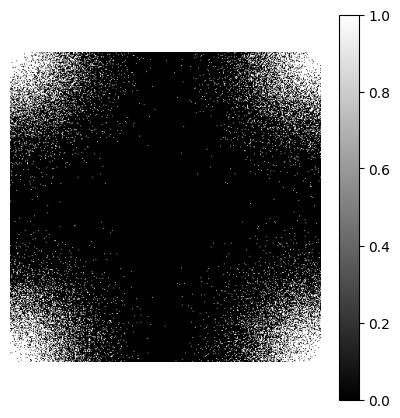

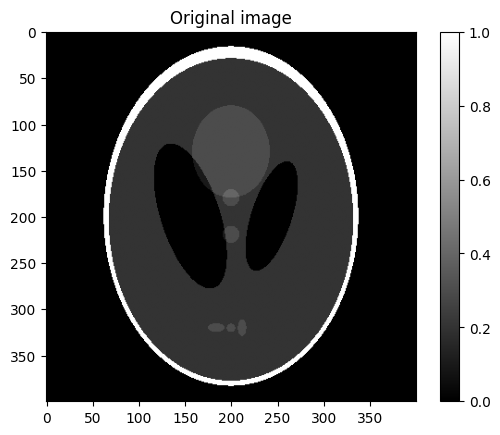

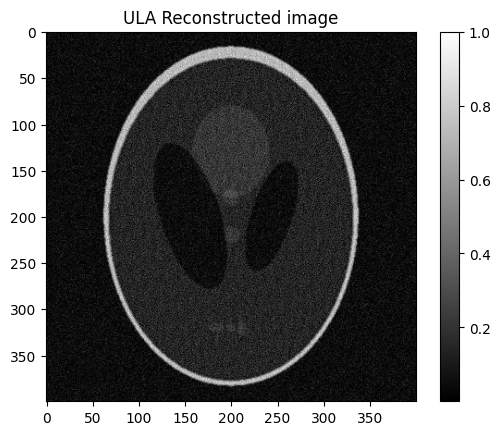

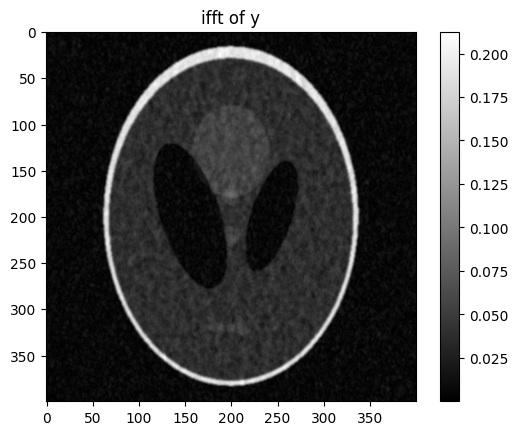

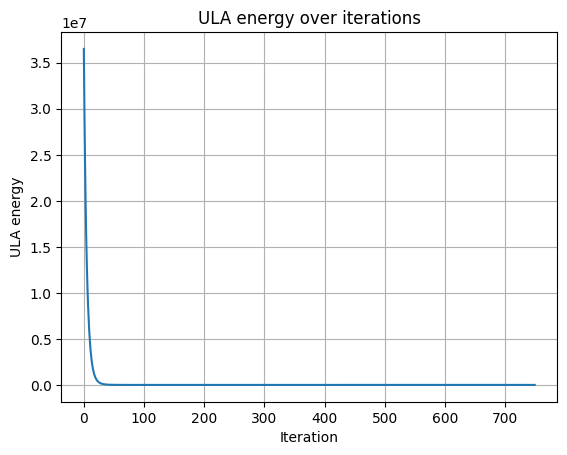

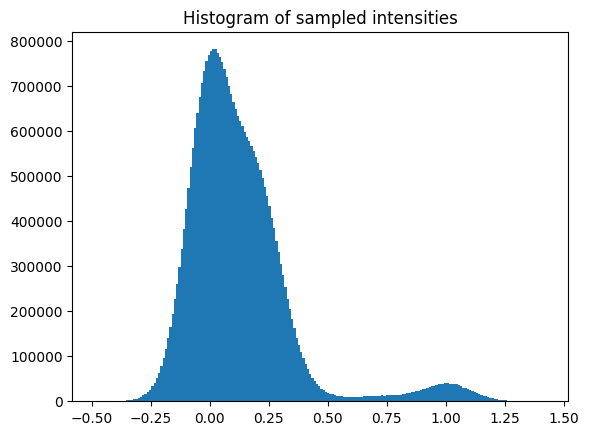

PSNR iFFT: 23.86 dB, NMSE iFFT: 0.0675, SSIM iFFT : 0.3303
None
PSNR ULA: 19.86 dB, NMSE ULA: 0.1698, SSIM ULA: 0.1606
None


In [2]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from utilities.masks import (
    PseudoRandomColumnMask,
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
    RadialMask
)
from utilities.metrics import ssim, nmse, psnr
from MAP.map_tv_minimize import MAPEstimator
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA

# load image
shepp_logan = ski.data.shepp_logan_phantom() # has values [0,1]
# normalize image
# shepp_logan = shepp_logan / np.max(np.abs(shepp_logan))

# create mask (in the F domain)
bernoulli_mask = BernoulliMask(0.88, seed=30).generate(shepp_logan.shape)
centered_bernoulli_mask = CenteredBernoulliMask(0.5, 0.15, seed=30).generate(
    shepp_logan.shape
)
vd_mask = VariableDensityMask('gaussian', 0.2, seed=30).generate(shepp_logan.shape) # default used decay_param=0.3 - 0.5
pseudorand_mask = PseudoRandomColumnMask(shepp_logan.shape, 2, 1, seed=30).get_mask()
radial_mask = RadialMask(shepp_logan.shape, 60, 0.12).generate()

# the 'actual' measurement
vd_mask_shift_corrected = np.fft.fftshift(vd_mask)
y= vd_mask_shift_corrected * np.fft.fft2(shepp_logan, norm='ortho')
# y_norm = y / np.max(np.abs(y))

# init the MAP and MMSE
map_estimator = MAPEstimator(vd_mask_shift_corrected, 0.1, 0.1, 1e-2, 1e-2, 300)
ula_estimator = MMSEEstimatorULA(vd_mask_shift_corrected, 0.01, 0.1, 5e-2, 1e-5, 350, 2, 200) 
mala_estimator = MMSEEstimatorMALA(vd_mask_shift_corrected, 0.005, 20*0.1, 1e-2, 1e-4, 350, 2, 200) # used previously (0.005, 20*0.1, 1e-2, 1e-4, 350, 2, 200)

# map_reconstruct = map_estimator.subgradient_descent(y)

samples, energies = ula_estimator.ula_sampling(y)
ula_mmse = ula_estimator.compute_mmse_estimate(samples)

# samples_kept, energies, step_trace, accept_trace = mala_estimator.mala_sampling(y)
# mala_mmse = mala_estimator.compute_mmse_estimate(samples_kept)

# plot mask
plt.figure(figsize=(5, 5))
plt.imshow(vd_mask_shift_corrected, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.colorbar()
plt.axis('off')
plt.show()
#plt.subplot(1, 3, 1)
plt.title("Original image")
plt.imshow(shepp_logan, cmap="gray")
plt.colorbar()
plt.show()     
# plt.subplot(1, 3, 2)
# plt.title("MAP Reconstructed image")
# plt.imshow(np.abs(map_reconstruct) / np.abs(map_reconstruct.max()), cmap="gray")
# plt.colorbar()
# plt.show()
plt.title("ULA Reconstructed image")
plt.imshow(np.abs(ula_mmse) / np.abs(ula_mmse.max()), cmap="gray")
plt.colorbar()
plt.show() 
# plt.title("MALA Reconstructed image")
# plt.imshow(np.abs(mala_mmse) / np.abs(mala_mmse.max()), cmap="gray")
# plt.colorbar()
# plt.show() 
#plt.subplot(1, 3, 3)
plt.title("ifft of y")
plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho') / np.abs(np.fft.ifft(y, norm='ortho').max())), cmap="gray")
plt.colorbar()
plt.show()     

# # ULA
# ula energy
plt.plot(energies)
plt.title("ULA energy over iterations")
plt.xlabel("Iteration")
plt.ylabel("ULA energy")
plt.grid(True)
#plt.yscale('log')
plt.show()

samples_array = np.array(samples)
plt.hist(samples_array.ravel(), bins=200)
plt.title("Histogram of sampled intensities")
plt.show()

# # MALA
# plt.figure(figsize=(14,6))
# plt.subplot(1,3,1)
# plt.plot(energies)
# plt.title('Energy trace')
# plt.xlabel("Iteration")
# plt.ylabel("MALA energy")
# plt.grid(True)
# plt.subplot(1,3,2)
# plt.plot(accept_trace / (np.arange(len(accept_trace))+1))
# plt.title('Cumulative accept rate')
# plt.subplot(1,3,3)
# plt.plot(step_trace)
# plt.title('Step size trace')
# plt.tight_layout()
# plt.show()

# metrics
psnr_ifft = psnr(np.abs(np.fft.ifft2(y, norm='ortho')), shepp_logan)
nmse_ifft = nmse(np.abs(np.fft.ifft2(y, norm='ortho')), shepp_logan)
ssim_ifft = ssim(np.abs(np.fft.ifft2(y, norm='ortho')), shepp_logan)
print(print(f"PSNR iFFT: {psnr_ifft:.2f} dB, NMSE iFFT: {nmse_ifft:.4f}, SSIM iFFT : {ssim_ifft:.4f}"))

# psnr_map = psnr(map_reconstruct.real, shepp_logan) # .real because shepp-logan is also real-valued
# nmse_map = nmse(map_reconstruct.real, shepp_logan)
# ssim_map = ssim(map_reconstruct.real, shepp_logan)
# print(print(f"PSNR MAP: {psnr_map:.2f} dB, NMSE MAP: {nmse_map:.4f}, SSIM MAP: {ssim_map:.4f}"))

psnr_ula = psnr(ula_mmse.real, shepp_logan) 
nmse_ula = nmse(ula_mmse.real, shepp_logan)
ssim_ula = ssim(ula_mmse.real, shepp_logan)
print(print(f"PSNR ULA: {psnr_ula:.2f} dB, NMSE ULA: {nmse_ula:.4f}, SSIM ULA: {ssim_ula:.4f}"))

# psnr_mala = psnr(mala_mmse.real, shepp_logan) 
# nmse_mala = nmse(mala_mmse.real, shepp_logan)
# ssim_mala = ssim(mala_mmse.real, shepp_logan)
# print(print(f"PSNR MALA: {psnr_mala:.2f} dB, NMSE MALA: {nmse_mala:.4f}, SSIM MALA: {ssim_mala:.4f}"))

# print(shepp_logan.min(), shepp_logan.max())
# print(np.abs(np.fft.ifft2(y, norm='ortho')).min(), np.abs(np.fft.ifft2(y, norm='ortho')).max())
# print(np.abs(map_reconstruct).min(), np.abs(map_reconstruct).max())


# # loss
# plt.plot(map_estimator.loss_history)
# plt.title("Loss over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.yscale('log')
# plt.show()

# # gradient
# plt.plot(map_estimator.grad_norm_history)
# plt.title("Gradient norm over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Gradient norm")
# plt.grid(True)
# #plt.yscale('log')
# plt.show()